In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0

In [6]:
# Parameters
dataset = "contraceptive"
dataset_name = "contraceptive"
single_model = "realtabformer"
gp = False
gp_multiply = False
random_seed = 3
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/contraceptive/realtabformer/3"
param_index = 2


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/contraceptive/realtabformer/3


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7c1d1278e3b0>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-03-01 09:08:01.341406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 09:08:01.341469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 09:08:01.343143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

In [15]:
preprocessor.adapter_sizes

{'tvae': 46,
 'realtabformer': (24, 72, Embedding(72, 672), True),
 'lct_gan': 40,
 'tab_ddpm_concat': 10}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset

test_set = load_dataset(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/", "datasets_5", dataset_name),
    preprocessor=preprocessor,
    cache_dir=os.path.join(path_prefix, dataset_name, "_cache_test"),
    start=200,
    #stop=600,
    val=False,
    ratio=0,
    drop_first_column=True,
    model=single_model,
)

Caching in ../../../../contraceptive/_cache_test/realtabformer/all inf False


In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 8,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'shared',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.775,
 'gradient_penalty_mode': {'gradient_penalty': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_data': 2,
 'dataset_size': 2048,


In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

load_dataset_3_factory 2
Caching in ../../../../contraceptive/_cache/realtabformer/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_2/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache4/realtabformer/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_4/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache5/realtabformer/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_5/contraceptive [160, 40]
[320, 80]
[320, 80]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding True True
['realtabformer'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

10911264

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1179, 16128]          --
├─Adapter: 1-1                                                         [2, 1179, 16128]          --
│    └─Embedding: 2-1                                                  [2, 1179, 24, 672]        (48,384)
│    └─TensorInductionPoint: 2-2                                       [24, 1]                   24
│    └─Sequential: 2-3                                                 [2, 1179, 256]            --
│    │    └─FeedForward: 3-1                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 1179, 1024]           689,152
│    │    │    └─Softsign: 4-2                                         [2, 1179, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 1179, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

clear_memory()

opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    whole_model=model,
    optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=False,
    wandb=wandb,
    study_name=study_name,
    **params
)

wandb: Tracking run with wandb version 0.16.3


wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.015214953777865503, 'avg_role_model_std_loss': 3.156637710683768, 'avg_role_model_mean_pred_loss': 0.0015362251463382382, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.015214953777865503, 'n_size': 320, 'n_batch': 160, 'duration': 150.5653796195984, 'duration_batch': 0.9410336226224899, 'duration_size': 0.47051681131124495, 'avg_pred_std': 0.06246557859708446}


Val loss {'avg_role_model_loss': 0.0029828296956111444, 'avg_role_model_std_loss': 3.72726428431983, 'avg_role_model_mean_pred_loss': 7.1439977092975506e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0029828296956111444, 'n_size': 80, 'n_batch': 40, 'duration': 35.29301643371582, 'duration_batch': 0.8823254108428955, 'duration_size': 0.44116270542144775, 'avg_pred_std': 0.017451438040006907}
Epoch 1


Train loss {'avg_role_model_loss': 0.005820814266519392, 'avg_role_model_std_loss': 3.788629152714401, 'avg_role_model_mean_pred_loss': 0.00012637018700479842, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.005820814266519392, 'n_size': 320, 'n_batch': 160, 'duration': 151.99716687202454, 'duration_batch': 0.9499822929501534, 'duration_size': 0.4749911464750767, 'avg_pred_std': 0.054377025530902755}


Val loss {'avg_role_model_loss': 0.003795744390345135, 'avg_role_model_std_loss': 4.469785842269539, 'avg_role_model_mean_pred_loss': 2.3026626298489063e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003795744390345135, 'n_size': 80, 'n_batch': 40, 'duration': 35.12023663520813, 'duration_batch': 0.8780059158802033, 'duration_size': 0.43900295794010163, 'avg_pred_std': 0.025538454634443042}
Epoch 2


Train loss {'avg_role_model_loss': 0.003438323737486826, 'avg_role_model_std_loss': 2.1381948816152487, 'avg_role_model_mean_pred_loss': 2.1238802406123302e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003438323737486826, 'n_size': 320, 'n_batch': 160, 'duration': 151.25162959098816, 'duration_batch': 0.945322684943676, 'duration_size': 0.472661342471838, 'avg_pred_std': 0.059417175995986324}


Val loss {'avg_role_model_loss': 0.0027740994402847717, 'avg_role_model_std_loss': 3.3004495511856193, 'avg_role_model_mean_pred_loss': 8.8964574990494e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0027740994402847717, 'n_size': 80, 'n_batch': 40, 'duration': 35.27286076545715, 'duration_batch': 0.8818215191364288, 'duration_size': 0.4409107595682144, 'avg_pred_std': 0.02031386639282573}
Epoch 3


Train loss {'avg_role_model_loss': 0.003000541084111319, 'avg_role_model_std_loss': 1.2077899141461088, 'avg_role_model_mean_pred_loss': 1.181568532097677e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003000541084111319, 'n_size': 320, 'n_batch': 160, 'duration': 151.62242531776428, 'duration_batch': 0.9476401582360268, 'duration_size': 0.4738200791180134, 'avg_pred_std': 0.0704218547190976}


Val loss {'avg_role_model_loss': 0.003368616230500265, 'avg_role_model_std_loss': 3.7329810831716825, 'avg_role_model_mean_pred_loss': 2.0277994416362245e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003368616230500265, 'n_size': 80, 'n_batch': 40, 'duration': 35.269885778427124, 'duration_batch': 0.8817471444606781, 'duration_size': 0.4408735722303391, 'avg_pred_std': 0.022317990543524503}
Epoch 4


Train loss {'avg_role_model_loss': 0.0021543572441999003, 'avg_role_model_std_loss': 2.36580728989997, 'avg_role_model_mean_pred_loss': 3.905246718544086e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0021543572441999003, 'n_size': 320, 'n_batch': 160, 'duration': 151.42908096313477, 'duration_batch': 0.9464317560195923, 'duration_size': 0.47321587800979614, 'avg_pred_std': 0.06814513673386387}


Val loss {'avg_role_model_loss': 0.0023375894830166997, 'avg_role_model_std_loss': 3.1858106834027735, 'avg_role_model_mean_pred_loss': 5.140880977472922e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023375894830166997, 'n_size': 80, 'n_batch': 40, 'duration': 35.21497082710266, 'duration_batch': 0.8803742706775666, 'duration_size': 0.4401871353387833, 'avg_pred_std': 0.022702036050031894}
Epoch 5


Train loss {'avg_role_model_loss': 0.0020639134972753937, 'avg_role_model_std_loss': 1.8771122450190234, 'avg_role_model_mean_pred_loss': 4.7617895551466114e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0020639134972753937, 'n_size': 320, 'n_batch': 160, 'duration': 150.65398001670837, 'duration_batch': 0.9415873751044274, 'duration_size': 0.4707936875522137, 'avg_pred_std': 0.06839547897311604}


Val loss {'avg_role_model_loss': 0.002713540389231639, 'avg_role_model_std_loss': 2.751661246550566, 'avg_role_model_mean_pred_loss': 8.476993637529517e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002713540389231639, 'n_size': 80, 'n_batch': 40, 'duration': 35.15806221961975, 'duration_batch': 0.8789515554904938, 'duration_size': 0.4394757777452469, 'avg_pred_std': 0.0216164964978816}
Epoch 6


Train loss {'avg_role_model_loss': 0.001974041026574014, 'avg_role_model_std_loss': 2.6116740645130543, 'avg_role_model_mean_pred_loss': 4.903630427295745e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.001974041026574014, 'n_size': 320, 'n_batch': 160, 'duration': 150.98297429084778, 'duration_batch': 0.9436435893177986, 'duration_size': 0.4718217946588993, 'avg_pred_std': 0.06690819428837073}


Val loss {'avg_role_model_loss': 0.0026584940679640567, 'avg_role_model_std_loss': 2.928696505277807, 'avg_role_model_mean_pred_loss': 1.0981135633864048e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0026584940679640567, 'n_size': 80, 'n_batch': 40, 'duration': 34.98962068557739, 'duration_batch': 0.8747405171394348, 'duration_size': 0.4373702585697174, 'avg_pred_std': 0.028631291013152805}
Epoch 7


Train loss {'avg_role_model_loss': 0.0017634188792953864, 'avg_role_model_std_loss': 1.5246528687675955, 'avg_role_model_mean_pred_loss': 4.08627352063845e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0017634188792953864, 'n_size': 320, 'n_batch': 160, 'duration': 151.10478925704956, 'duration_batch': 0.9444049328565598, 'duration_size': 0.4722024664282799, 'avg_pred_std': 0.06988477217641957}


Val loss {'avg_role_model_loss': 0.0025102962197934174, 'avg_role_model_std_loss': 3.828912246527557, 'avg_role_model_mean_pred_loss': 9.336235920053004e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0025102962197934174, 'n_size': 80, 'n_batch': 40, 'duration': 35.14225649833679, 'duration_batch': 0.8785564124584198, 'duration_size': 0.4392782062292099, 'avg_pred_std': 0.025317877356610553}
Epoch 8


Train loss {'avg_role_model_loss': 0.0017970734881543216, 'avg_role_model_std_loss': 1.9675439566956825, 'avg_role_model_mean_pred_loss': 4.507927208244523e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0017970734881543216, 'n_size': 320, 'n_batch': 160, 'duration': 151.0646207332611, 'duration_batch': 0.9441538795828819, 'duration_size': 0.47207693979144094, 'avg_pred_std': 0.06440023747350096}


Val loss {'avg_role_model_loss': 0.0029548812297832683, 'avg_role_model_std_loss': 2.1843356087258696, 'avg_role_model_mean_pred_loss': 1.6957902914016554e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0029548812297832683, 'n_size': 80, 'n_batch': 40, 'duration': 35.090479135513306, 'duration_batch': 0.8772619783878326, 'duration_size': 0.4386309891939163, 'avg_pred_std': 0.028445404235390014}
Epoch 9


Train loss {'avg_role_model_loss': 0.0016425128245685983, 'avg_role_model_std_loss': 2.024512654822502, 'avg_role_model_mean_pred_loss': 3.285046532060373e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016425128245685983, 'n_size': 320, 'n_batch': 160, 'duration': 150.84772562980652, 'duration_batch': 0.9427982851862907, 'duration_size': 0.47139914259314536, 'avg_pred_std': 0.0747756733842209}


Val loss {'avg_role_model_loss': 0.002334522669548278, 'avg_role_model_std_loss': 2.7116857997084027, 'avg_role_model_mean_pred_loss': 6.992434950987836e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002334522669548278, 'n_size': 80, 'n_batch': 40, 'duration': 35.245197772979736, 'duration_batch': 0.8811299443244934, 'duration_size': 0.4405649721622467, 'avg_pred_std': 0.026337641538702883}
Epoch 10


Train loss {'avg_role_model_loss': 0.0016268517200273892, 'avg_role_model_std_loss': 1.4290221301512553, 'avg_role_model_mean_pred_loss': 2.7465491623539574e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016268517200273892, 'n_size': 320, 'n_batch': 160, 'duration': 150.6063461303711, 'duration_batch': 0.9412896633148193, 'duration_size': 0.47064483165740967, 'avg_pred_std': 0.07696705762027704}


Val loss {'avg_role_model_loss': 0.0022422952166834876, 'avg_role_model_std_loss': 3.8237469222483185, 'avg_role_model_mean_pred_loss': 4.734226487249082e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022422952166834876, 'n_size': 80, 'n_batch': 40, 'duration': 35.0414342880249, 'duration_batch': 0.8760358572006226, 'duration_size': 0.4380179286003113, 'avg_pred_std': 0.02215462920921709}
Epoch 11


Train loss {'avg_role_model_loss': 0.001684735846095009, 'avg_role_model_std_loss': 1.8539249592111176, 'avg_role_model_mean_pred_loss': 3.617836458871815e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.001684735846095009, 'n_size': 320, 'n_batch': 160, 'duration': 151.0113205909729, 'duration_batch': 0.9438207536935806, 'duration_size': 0.4719103768467903, 'avg_pred_std': 0.06602817026396224}


Val loss {'avg_role_model_loss': 0.0023927180209284415, 'avg_role_model_std_loss': 1.9305211880035131, 'avg_role_model_mean_pred_loss': 8.37876484468536e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023927180209284415, 'n_size': 80, 'n_batch': 40, 'duration': 35.019232988357544, 'duration_batch': 0.8754808247089386, 'duration_size': 0.4377404123544693, 'avg_pred_std': 0.02876366543350741}
Epoch 12


Train loss {'avg_role_model_loss': 0.001648270361597781, 'avg_role_model_std_loss': 1.466464621800828, 'avg_role_model_mean_pred_loss': 3.6850406459681182e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.001648270361597781, 'n_size': 320, 'n_batch': 160, 'duration': 150.67579007148743, 'duration_batch': 0.9417236879467964, 'duration_size': 0.4708618439733982, 'avg_pred_std': 0.07282405201085566}


Val loss {'avg_role_model_loss': 0.0024106145921905407, 'avg_role_model_std_loss': 1.8117562619359986, 'avg_role_model_mean_pred_loss': 8.840941997867446e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0024106145921905407, 'n_size': 80, 'n_batch': 40, 'duration': 35.25731110572815, 'duration_batch': 0.8814327776432037, 'duration_size': 0.44071638882160186, 'avg_pred_std': 0.028296888258773835}
Epoch 13


Train loss {'avg_role_model_loss': 0.0014949767563791738, 'avg_role_model_std_loss': 2.0110324508543216, 'avg_role_model_mean_pred_loss': 2.594263938809541e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0014949767563791738, 'n_size': 320, 'n_batch': 160, 'duration': 150.59481382369995, 'duration_batch': 0.9412175863981247, 'duration_size': 0.47060879319906235, 'avg_pred_std': 0.07127468679950652}


Val loss {'avg_role_model_loss': 0.0034006003257673, 'avg_role_model_std_loss': 2.3089766705088124, 'avg_role_model_mean_pred_loss': 2.330103268749495e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0034006003257673, 'n_size': 80, 'n_batch': 40, 'duration': 35.14684081077576, 'duration_batch': 0.8786710202693939, 'duration_size': 0.43933551013469696, 'avg_pred_std': 0.03264807362284046}
Epoch 14


Train loss {'avg_role_model_loss': 0.0014807669692402214, 'avg_role_model_std_loss': 1.486915388038304, 'avg_role_model_mean_pred_loss': 2.468103663008994e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0014807669692402214, 'n_size': 320, 'n_batch': 160, 'duration': 150.8731460571289, 'duration_batch': 0.9429571628570557, 'duration_size': 0.47147858142852783, 'avg_pred_std': 0.06568786399493547}


Val loss {'avg_role_model_loss': 0.002275905742408213, 'avg_role_model_std_loss': 2.4593560876942546, 'avg_role_model_mean_pred_loss': 5.3657121410810585e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002275905742408213, 'n_size': 80, 'n_batch': 40, 'duration': 35.17850923538208, 'duration_batch': 0.879462730884552, 'duration_size': 0.439731365442276, 'avg_pred_std': 0.028419802509597504}
Epoch 15


Train loss {'avg_role_model_loss': 0.0013959772029608075, 'avg_role_model_std_loss': 1.5552767487895864, 'avg_role_model_mean_pred_loss': 2.032669835160851e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013959772029608075, 'n_size': 320, 'n_batch': 160, 'duration': 145.97118186950684, 'duration_batch': 0.9123198866844178, 'duration_size': 0.4561599433422089, 'avg_pred_std': 0.0743303620764891}


Val loss {'avg_role_model_loss': 0.0021730058373577777, 'avg_role_model_std_loss': 3.265071701107611, 'avg_role_model_mean_pred_loss': 5.249506042540042e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0021730058373577777, 'n_size': 80, 'n_batch': 40, 'duration': 32.64319920539856, 'duration_batch': 0.816079980134964, 'duration_size': 0.408039990067482, 'avg_pred_std': 0.02472462045188877}
Epoch 16


Train loss {'avg_role_model_loss': 0.0013986327389147845, 'avg_role_model_std_loss': 1.0404113516639566, 'avg_role_model_mean_pred_loss': 2.472861648920811e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013986327389147845, 'n_size': 320, 'n_batch': 160, 'duration': 142.02302479743958, 'duration_batch': 0.8876439049839974, 'duration_size': 0.4438219524919987, 'avg_pred_std': 0.0766021506049583}


Val loss {'avg_role_model_loss': 0.0021833765216797475, 'avg_role_model_std_loss': 1.9410757024995746, 'avg_role_model_mean_pred_loss': 5.971337235900851e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0021833765216797475, 'n_size': 80, 'n_batch': 40, 'duration': 33.03069186210632, 'duration_batch': 0.8257672965526581, 'duration_size': 0.41288364827632906, 'avg_pred_std': 0.029009606450563295}
Epoch 17


Train loss {'avg_role_model_loss': 0.0013606195244022957, 'avg_role_model_std_loss': 1.2219324406304888, 'avg_role_model_mean_pred_loss': 2.558043809543567e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013606195244022957, 'n_size': 320, 'n_batch': 160, 'duration': 142.88847541809082, 'duration_batch': 0.8930529713630676, 'duration_size': 0.4465264856815338, 'avg_pred_std': 0.07105417825841868}


Val loss {'avg_role_model_loss': 0.0025992857859819195, 'avg_role_model_std_loss': 4.460525457162658, 'avg_role_model_mean_pred_loss': 1.0201318598324071e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0025992857859819195, 'n_size': 80, 'n_batch': 40, 'duration': 32.683080196380615, 'duration_batch': 0.8170770049095154, 'duration_size': 0.4085385024547577, 'avg_pred_std': 0.02676110131196765}
Epoch 18


Train loss {'avg_role_model_loss': 0.0013010777075521673, 'avg_role_model_std_loss': 0.9639209467314742, 'avg_role_model_mean_pred_loss': 2.0914453604690185e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013010777075521673, 'n_size': 320, 'n_batch': 160, 'duration': 141.19299387931824, 'duration_batch': 0.882456211745739, 'duration_size': 0.4412281058728695, 'avg_pred_std': 0.07996181348535174}


Val loss {'avg_role_model_loss': 0.0021221282840997446, 'avg_role_model_std_loss': 2.53250820556988, 'avg_role_model_mean_pred_loss': 6.020639418136131e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0021221282840997446, 'n_size': 80, 'n_batch': 40, 'duration': 32.62534475326538, 'duration_batch': 0.8156336188316345, 'duration_size': 0.40781680941581727, 'avg_pred_std': 0.028227102017262952}
Epoch 19


wandb:                                                                                


Train loss {'avg_role_model_loss': 0.0013113658649871241, 'avg_role_model_std_loss': 1.157548566752187, 'avg_role_model_mean_pred_loss': 2.71372324170595e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013113658649871241, 'n_size': 320, 'n_batch': 160, 'duration': 141.17731380462646, 'duration_batch': 0.8823582112789154, 'duration_size': 0.4411791056394577, 'avg_pred_std': 0.06990279755846132}
Time out: 3691.47634100914/3600


wandb: 
wandb: Run history:
wandb:                       avg_loss_test ▅█▄▆▂▃▃▃▄▂▂▂▂▆▂▁▁▃▁
wandb:                      avg_loss_train █▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_embed_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_embed_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                   avg_pred_std_test ▁▅▂▃▃▃▆▅▆▅▃▆▆█▆▄▆▅▆
wandb:                  avg_pred_std_train ▃▁▂▅▅▅▄▅▄▇▇▄▆▆▄▆▇▆█
wandb:      avg_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      avg_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            avg_role_model_loss_test ▅█▄▆▂▃▃▃▄▂▂▂▂▆▂▁▁▃▁
wandb:           avg_role_m

wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/eval/contraceptive/realtabformer/3/wandb/offline-run-20240301_090815-dmvtx8gf


wandb: Find logs at: ./wandb/offline-run-20240301_090815-dmvtx8gf/logs


/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


Eval loss {'role_model': 'realtabformer', 'n_size': 399, 'n_batch': 200, 'role_model_metrics': {'avg_loss': 0.001492384186390257, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.009758013392212732, 'pred_duration': 4.686195373535156, 'grad_duration': 2.4317636489868164, 'total_duration': 7.117959022521973, 'pred_std': 0.05503244325518608, 'std_loss': 0.021272432059049606, 'mean_pred_loss': 1.4633540104114218e-06, 'pred_rmse': 0.0386313833296299, 'pred_mae': 0.030890200287103653, 'pred_mape': 0.07129626721143723, 'grad_rmse': 0.24003435671329498, 'grad_mae': 0.11075862497091293, 'grad_mape': 1.6372917890548706}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.001492384186390257, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.009758013392212732, 'avg_pred_duration': 4.686195373535156, 'avg_grad_du

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

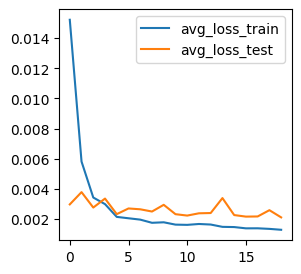

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  \
realtabformer        0.015449             NaN  0.001492       2.446578   

               grad_mae  grad_mape  grad_rmse  mean_pred_loss  pred_duration  \
realtabformer  0.110759   1.637292   0.240034        0.000001       4.698303   

               pred_mae  pred_mape  pred_rmse  pred_std  std_loss  \
realtabformer   0.03089   0.071296   0.038631  0.055032  0.021272   

               total_duration  
realtabformer        7.144881

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../contraceptive/_cache_test/realtabformer/all inf False


/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'realtabformer': 0.4290029579087308}


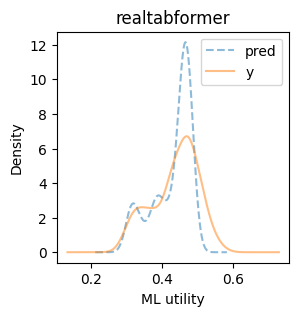

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

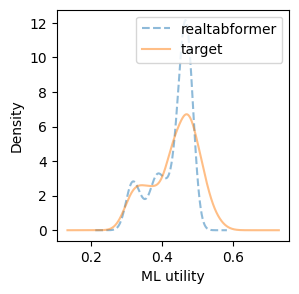

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

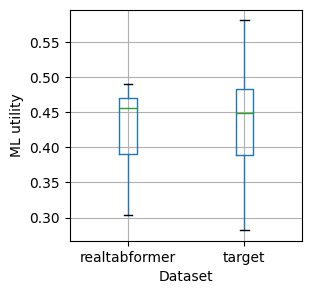

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

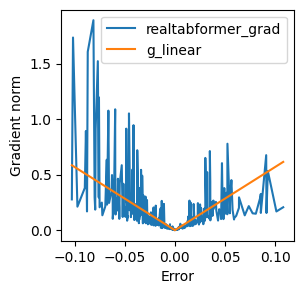

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""